In [1]:
import torch
import lightning as L
import lightning.pytorch as pl
from pl_model import PLModel
import numpy as np
from dataset import TitanicDataset

pl.seed_everything(0)
# path = "ckpt/best_f1/epoch=39-valBinaryF1Score=0.7651-valBinaryRecall=0.7500-valBinaryPrecision=0.7808-valBinaryAveragePrecision=0.8012-valBinaryAUROC=0.8098.ckpt"
path = "ckpt/best_f1/epoch=39-valBinaryF1Score=0.7651-valBinaryRecall=0.7500-valBinaryPrecision=0.7808-valBinaryAveragePrecision=0.8018-valBinaryAUROC=0.8107.ckpt"
pl_model = PLModel.load_from_checkpoint(path)
model = pl_model.model
model = model.eval()

Seed set to 0


In [2]:
recalls = []
precisions = []
f1_scores = []
average_precisions = []
roc_aucs = []

dataset = TitanicDataset("./data", scope="VAL")
x: list[torch.Tensor] = []
target: list[torch.Tensor] = []
for _x, _target in dataset:
    x.append(_x)
    target.append(_target)

with torch.no_grad():
    x_tensor = torch.stack(x)
    target_tensor = torch.stack(target)
    y = model.forward(x_tensor.to(pl_model.device))
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score, roc_auc_score
y_pred = (y.cpu() > 0.5).to(torch.int).numpy()
target_tensor = target_tensor.cpu().numpy()
recall = recall_score(target_tensor, y_pred)
precision = precision_score(target_tensor, y_pred)
f1 = f1_score(target_tensor, y_pred)
ap = average_precision_score(target_tensor, y.cpu().numpy())
roc_auc = roc_auc_score(target_tensor, y.cpu().numpy())
recalls.append(recall)
precisions.append(precision)
f1_scores.append(f1)
average_precisions.append(ap)
roc_aucs.append(roc_auc)

print(f"Recall: {np.mean(recalls):.4f}, {np.std(recalls):.4f}, {np.max(recalls) - np.mean(recalls): .4f}, {np.mean(recalls) - np.min(recalls): .4f}")
print(f"Precision: {np.mean(precisions):.4f}, {np.std(precisions):.4f}, {np.max(precisions) - np.mean(precisions): .4f}, {np.mean(precisions) - np.min(precisions): .4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}, {np.std(f1_scores):.4f}, {np.max(f1_scores) - np.mean(f1_scores): .4f}, {np.mean(f1_scores) - np.min(f1_scores): .4f}")
print(f"Average Precision: {np.mean(average_precisions):.4f}, {np.std(average_precisions):.4f}, {np.max(average_precisions) - np.mean(average_precisions): .4f}, {np.mean(average_precisions) - np.min(average_precisions): .4f}")
print(f"ROC AUC Score: {np.mean(roc_aucs):.4f}, {np.std(roc_aucs):.4f}, {np.max(roc_aucs) - np.mean(roc_aucs): .4f}, {np.mean(roc_aucs) - np.min(roc_aucs): .4f}")

Recall: 0.7500, 0.0000,  0.0000,  0.0000
Precision: 0.7808, 0.0000,  0.0000,  0.0000
F1 Score: 0.7651, 0.0000,  0.0000,  0.0000
Average Precision: 0.8014, 0.0000,  0.0000,  0.0000
ROC AUC Score: 0.8111, 0.0000,  0.0000,  0.0000


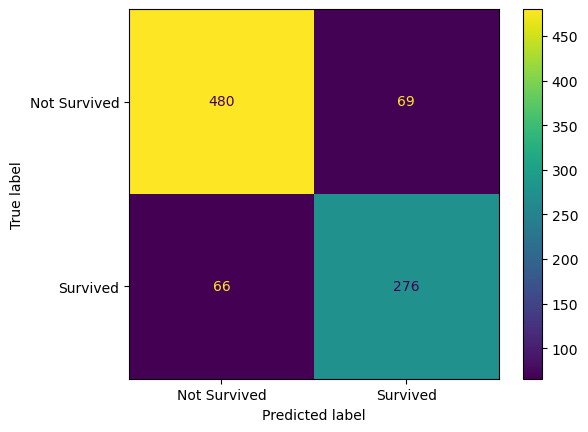

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

dataset = TitanicDataset("./data", scope="ALL")
x: list[torch.Tensor] = []
target: list[torch.Tensor] = []
for _x, _target in dataset:
    x.append(_x)
    target.append(_target)
with torch.no_grad():
    x_tensor = torch.stack(x)
    target_tensor = torch.stack(target)
    y = model.forward(x_tensor.to(pl_model.device))
y_pred = (y.cpu() > 0.5).to(torch.int).numpy()
target_tensor = target_tensor.cpu().numpy()
cm = confusion_matrix(target_tensor, (y.cpu() > 0.5).to(torch.int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])
disp.plot()


In [4]:
import pickle


cmp_model_files = ["cmp_svm_model.pkl", "cmp_decision_tree_model.pkl", "cmp_logistic_regression_model.pkl", "cmp_random_forest_model.pkl"]
def load_cmp_models(cmp_model_file: str):
    with open(cmp_model_file, 'rb') as f:
        return pickle.load(f)
cmp_models = [load_cmp_models(file) for file in cmp_model_files]
model_names = ["SVM", "Decision Tree", "Logistic Regression", "Random Forest"]
model_dict = {name: model for name, model in zip(model_names, cmp_models)}
for model_name, model in model_dict.items():
    recalls = []
    precisions = []
    f1_scores = []
    average_precisions = []
    roc_aucs = []
    accuracy_scores = []

    dataset = TitanicDataset("./data", scope="VAL")
    x: list[torch.Tensor] = []
    target: list[torch.Tensor] = []
    for _x, _target in dataset:
        x.append(_x)
        target.append(_target)

    x_tensor = torch.stack(x)
    x_np = x_tensor.numpy()
    target_tensor = torch.stack(target)
    target_np = target_tensor.numpy()
    y: np.ndarray = model.predict(x_np)

    from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score, roc_auc_score, accuracy_score
    y_pred = (y > 0.5).astype(np.int_)
    recall = recall_score(target_np, y_pred)
    precision = precision_score(target_np, y_pred)
    f1 = f1_score(target_np, y_pred)
    ap = average_precision_score(target_np, y)
    roc_auc = roc_auc_score(target_np, y)
    accuracy_score = accuracy_score(target_np, y_pred)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    average_precisions.append(ap)
    roc_aucs.append(roc_auc)
    accuracy_scores.append(accuracy_score)

    print(f"{model_name} Recall: {np.mean(recalls):.4f}, {np.std(recalls):.4f}, {np.max(recalls) - np.mean(recalls): .4f}, {np.mean(recalls) - np.min(recalls): .4f}")
    print(f"{model_name} Precision: {np.mean(precisions):.4f}, {np.std(precisions):.4f}, {np.max(precisions) - np.mean(precisions): .4f}, {np.mean(precisions) - np.min(precisions): .4f}")
    print(f"{model_name} F1 Score: {np.mean(f1_scores):.4f}, {np.std(f1_scores):.4f}, {np.max(f1_scores) - np.mean(f1_scores): .4f}, {np.mean(f1_scores) - np.min(f1_scores): .4f}")
    print(f"{model_name} Average Precision: {np.mean(average_precisions):.4f}, {np.std(average_precisions):.4f}, {np.max(average_precisions) - np.mean(average_precisions): .4f}, {np.mean(average_precisions) - np.min(average_precisions): .4f}")
    print(f"{model_name} ROC AUC Score: {np.mean(roc_aucs):.4f}, {np.std(roc_aucs):.4f}, {np.max(roc_aucs) - np.mean(roc_aucs): .4f}, {np.mean(roc_aucs) - np.min(roc_aucs): .4f}")
    print(f"{model_name} Accuracy Score: {np.mean(accuracy_scores):.4f}, {np.std(accuracy_scores):.4f}, {np.max(accuracy_scores) - np.mean(accuracy_scores): .4f}, {np.mean(accuracy_scores) - np.min(accuracy_scores): .4f}")

SVM Recall: 0.2763, 0.0000,  0.0000,  0.0000
SVM Precision: 0.6774, 0.0000,  0.0000,  0.0000
SVM F1 Score: 0.3925, 0.0000,  0.0000,  0.0000
SVM Average Precision: 0.4944, 0.0000,  0.0000,  0.0000
SVM ROC AUC Score: 0.5896, 0.0000,  0.0000,  0.0000
SVM Accuracy Score: 0.6369, 0.0000,  0.0000,  0.0000
Decision Tree Recall: 0.7237, 0.0000,  0.0000,  0.0000
Decision Tree Precision: 0.7534, 0.0000,  0.0000,  0.0000
Decision Tree F1 Score: 0.7383, 0.0000,  0.0000,  0.0000
Decision Tree Average Precision: 0.6626, 0.0000,  0.0000,  0.0000
Decision Tree ROC AUC Score: 0.7745, 0.0000,  0.0000,  0.0000
Decision Tree Accuracy Score: 0.7821, 0.0000,  0.0000,  0.0000
Logistic Regression Recall: 0.6184, 0.0000,  0.0000,  0.0000
Logistic Regression Precision: 0.7581, 0.0000,  0.0000,  0.0000
Logistic Regression F1 Score: 0.6812, 0.0000,  0.0000,  0.0000
Logistic Regression Average Precision: 0.6308, 0.0000,  0.0000,  0.0000
Logistic Regression ROC AUC Score: 0.7364, 0.0000,  0.0000,  0.0000
Logistic R